In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from time import sleep

## A: Plot the Lennard-Jones Potential ## 

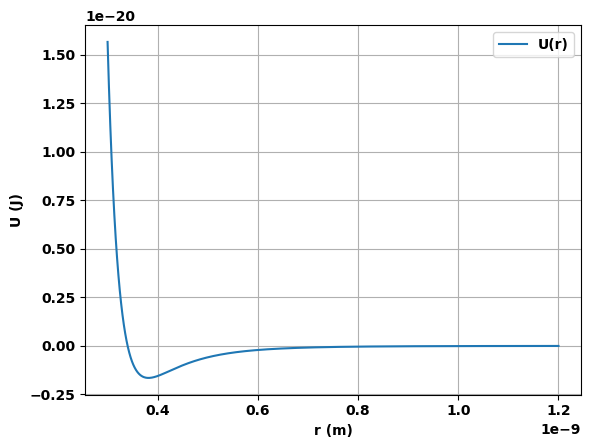

In [2]:
def LennardJ(r):
    eps=1.65e-21
    sig=3.4e-10
    U=4*(eps)*((sig/r)**(12)-(sig/r)**(6))
    return U
r_space=np.linspace(3e-10,12e-10,1000)
plt.plot(r_space,LennardJ(r_space))
plt.xlabel("r (m)")
plt.ylabel("U (J)")
plt.grid(True)
plt.legend(["U(r)"])

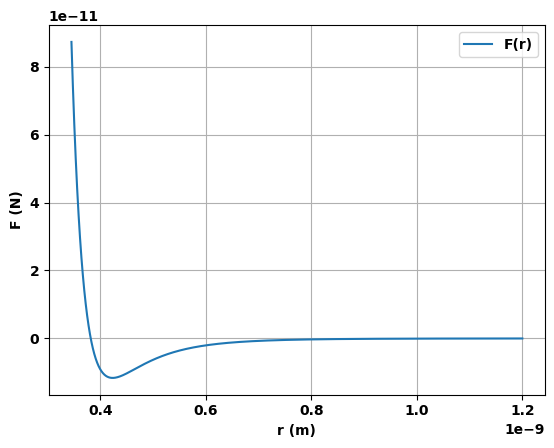

In [3]:
#F=-grad(U)=-dU/dr
def Lennard_force(r):
    eps=1.65e-21
    sig=3.4e-10
    F=((-24*eps*(sig**6))/r**7)*(1-2*(sig/r)**6)
    return F
plt.plot(r_space[50:],Lennard_force(r_space[50:]))
#plt.plot(r_space,Lennard_force(r_space))
plt.xlabel("r (m)")
plt.ylabel("F (N)")
plt.grid(True)
plt.legend(['F(r)'])
#r_0=sigma*(2**(1/6))


## B ##

In [4]:
def pos1(pos0,vel0,a0,dt):
    return pos0+vel0*dt+0.5*a0*(dt**2)
def vel1(vel0,a1,a0,dt):
    return vel0+0.5*(a1+a0)*(dt)

In [5]:
def Nearest_Instance(pos_i,pos_j,L_a):
    dx=pos_i-pos_j
    if dx>0.5*L_a:
        dx=dx-L_a
    elif dx<-0.5*L_a:
        dx=dx+L_a
    return dx

In [6]:
x = [1.09, 3.12, 0.08, 0.54, 2.52, 3.03, 4.25, 0.89, 2.76, 3.14, 0.23, 1.91, 4.77, 5.1, 4.97, 3.9]
y = [0.98, 5.25, 2.38, 4.08, 4.39, 2.94, 3.01, 3.11, 0.31, 1.91, 5.71, 2.46, 0.96, 4.63, 5.88, 0.2]
v_x = [-0.33, 0.12,-0.09,-1.94, 0.75, 1.7, 0.84,-1.04, 1.64, 0.38,-1.58,-1.55,-0.23,-0.31, 1.18, 0.46]
v_y = [0.78,-1.19,-0.1,-0.56, 0.34,-1.08, 0.47, 0.06, 1.36,-1.24, 0.55,-0.16,-0.83, 0.65, 1.48,-0.53]
#Changed vy[0] to 1.78 and vy[3] to -1.1
print(np.sum(v_x))
print(np.sum(v_y))

-8.881784197001252e-16
4.440892098500626e-16


In [7]:
def Distances_to_Nearests(positions,L=6):
    #calccount is to ensure we are only running the function half the times
    calccount=0
    #By doing as a function, reduces the number of variables in global scope
    nx1=np.zeros((len(positions),len(positions)))
    #Zeros is more predicatable and typically more efficient than empty
    #print(nx1)
    for i in range(0,len(nx1)):
        for j in range(0,len(nx1[i])):
            if i==j:
                nx1[i][j]=np.nan
                #Would prefer do to string but dtype of np.zeroes is float
            else:
                if np.abs(nx1[i][j])<1e-9:
                    #Cant really equate with floats so this checks if the number has not been changed and therefore written
                    dist_x=Nearest_Instance(positions[i],positions[j],L)
                    calccount+=1
                    nx1[i][j]=dist_x
                    nx1[j][i]=-dist_x
                else:
                    if nx1[i][j]!=-nx1[j][i]:
                        print(i,j)
                        print(nx1[i][j],nx1[j,i])
                        print("Something has gone wrong")
    #print(calccount)
    nx1[-1][-1]=np.nan
    return nx1

In [8]:
def Force_calc(dx,dy):
    r=np.sqrt((dx)**2+(dy)**2)
    #Redid this function since last sending this, I had done it slightly differently and accidentally changed the powers of one of the components
    F_tot=48*(((r**(-13))-0.5*(r**(-7))))
    F_x=F_tot*(dx/r)
    F_y=F_tot*(dy/r)
    return F_x,F_y
def Pot_calc(dx,dy):
    r=np.sqrt((dx)**2+(dy)**2)
    u=4*(r**(-12)-r**(-6))
    return u
    

In [9]:
def Net_Force_U_Calc(dxs,dys):
    calccount=0
    x_forces=np.zeros(np.shape(dxs))
    y_forces=np.zeros(np.shape(dys))
    U_array=np.zeros(np.shape(dxs))
    for i in range(0,len(dxs)):
        for j in range (0,len(dxs[i])):
            if (dxs[i][j]!=np.nan) & (dys[i][j]!=np.nan)&(np.abs(x_forces[i][j])<1e-9)&(np.abs(y_forces[i][j])<1e-9):
                #print(i,j)
                F_x,F_y=Force_calc(dxs[i][j],dys[i][j])
                Pot=Pot_calc(dxs[i][j],dys[i][j])
                calccount+=1
                #It looks like its counting a few too many times? Should be 120 but is doing 136
                #This takes advantage of NIII
                x_forces[i][j]=F_x
                x_forces[j][i]=-F_x
                y_forces[i][j]=F_y
                y_forces[j][i]=-F_y
                U_array[i][j]=Pot
                U_array[j][i]=Pot

    #print(calccount)
    Net_x_Forces=[np.nansum(el) for el in x_forces]
    Net_y_Forces=[np.nansum(el) for el in y_forces]
    Net_Potentials=[np.nansum(el) for el in U_array]
    return Net_x_Forces,Net_y_Forces,Net_Potentials



In [10]:
def Mover(Posx0,Posy0,v_x0,v_y0,tmax,dt=0.01,L=6):
    Tot_Pots=[]
    Tot_kin=[]
    Left_nums=[]
    x_array=[]
    y_array=[]
    vx_array=[]
    vy_array=[]
    ax_array=[]
    ay_array=[]
    #The : in the following statements are to make copies to prevent changing original
    x0=Posx0[:]
    y0=Posy0[:]
    vx0=v_x0[:]
    vy0=v_y0[:]
    ax0=np.zeros(len(Posx0))
    ay0=np.zeros(len(Posx0))
    ax1=np.zeros(len(Posx0))
    ay1=np.zeros(len(Posx0))
    t=0
    while t<tmax:
        #Get nearest distances
        dxs=Distances_to_Nearests(x0,L)
        dys=Distances_to_Nearests(y0,L)
        #Get x,y net forces and potential
        xf,yf,FPots=Net_Force_U_Calc(dxs,dys)
        Tot_Pots.append(np.nansum(FPots))
        #Get kinetic energy
        Tot_kin.append(np.sum([0.5*v**2 for v in vx0]+[0.5*v**2 for v in vy0]))
        #Get number of molecules on left side
        Left_num=len([x for x in x0 if 0<=x<=L/2])
        Left_nums.append(Left_num)
        #prep for movement by noting current values 
        x_array.append(x0)
        y_array.append(y0)
        vx_array.append(vx0)
        vy_array.append(vy0)
        ax_array.append(ax1)
        ay_array.append(ay1)
        #movement
        ax0=xf[:]
        ay0=yf[:]
        #This copy stuff was found to be needed due to way python decides to work in terms of value by reference
        #The issue was that it was computing the new values, replacing the values and then duplicating these new values
        copy_x0=x0[:]
        copy_y0=y0[:]
        copy_vx0=vx0[:]
        copy_vy0=vy0[:]
        for i in range(0,len(x0)):
            copy_x0[i]=pos1(x0[i],vx0[i],ax0[i],dt)
            copy_y0[i]=pos1(y0[i],vy0[i],ay0[i],dt)
            #copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
            #copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt)
            if copy_x0[i]>L:
                #print('test1',copy_x0[i])
                copy_x0[i]=copy_x0[i]%L
                #print(copy_x0[i])
            if copy_x0[i]<0:
                #print('test2',copy_x0[i])
                copy_x0[i]=L-np.abs(copy_x0[i])%L
                #print(copy_x0[i])
            if copy_y0[i]>L:
                #print('test3',copy_y0[i])
                copy_y0[i]=copy_y0[i]%L
                #print(copy_y0[i])
            if copy_y0[i]<0:
                #print('test4',copy_y0[i])
                copy_y0[i]=L-np.abs(copy_y0[i])%L
                #print(copy_y0[i])
        #This duplication of things is likely not particularly efficient
        dxs1=Distances_to_Nearests(copy_x0,L)
        dys1=Distances_to_Nearests(copy_y0,L)
        xf1,yf1,FPots1=Net_Force_U_Calc(dxs1,dys1)
        ax1=xf1[:]
        ay1=yf1[:]
        for i in range(0,len(x0)):
           copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
           copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt) 
        x0=copy_x0[:]
        y0=copy_y0[:]
        vx0=copy_vx0[:]
        vy0=copy_vy0[:]
        ax0=ax1[:]
        ay0=ay1[:]


        t+=dt
    #print(np.shape(x_array))
    return Tot_Pots,Tot_kin,Left_nums,x_array,y_array,vx_array,vy_array,ax_array,ay_array

In [32]:
#If rerunning this probably reduce to 100 to get a reasonable running time
#Changing the time step to compare
u_1,k_1,l_1,x_1,y_1,vx_1,vy_1,ax_1,ay_1=Mover(x,y,v_x,v_y,1000,dt=0.02)
#print(x_1[0])

print(len(x_1))


50001


Text(0.5, 1.0, 'Potential energy evolution of part b')

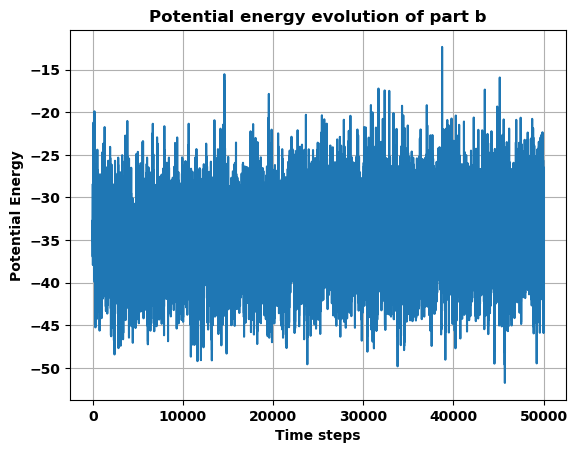

In [34]:
plt.plot(u_1)
plt.grid(True)
plt.xlabel('Time steps')
plt.ylabel('Potential Energy')
plt.title('Potential energy evolution of part b')
#plt.ylim(-100,1e+5)
#plt.xlim(200,300)

21.655959395147764
17.210466874860153
17.178776696307946


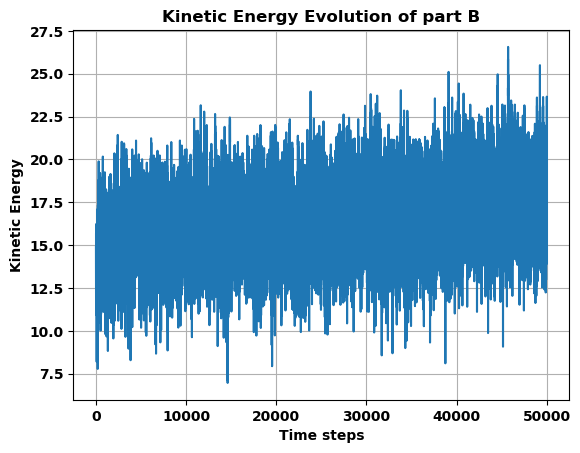

In [35]:
plt.plot(k_1)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Kinetic Energy")
plt.title("Kinetic Energy Evolution of part B")
print(k_1[-1])
print(np.median(k_1[5000:]))
print(np.average(k_1[5000:]))
#plt.xlim(0,1000)
#plt.ylim(0,1e+1)

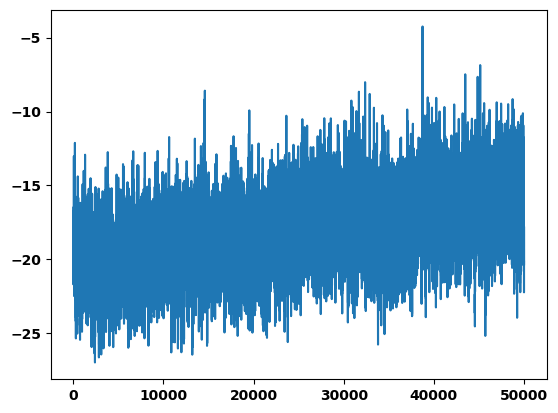

In [36]:
E_tot=[]
for i in range(0,len(k_1)):
    E_tot.append(k_1[i]+u_1[i])
plt.plot(E_tot)

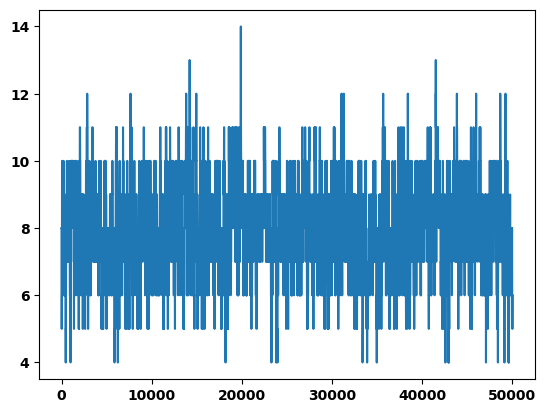

In [37]:
plt.plot(l_1)

In [38]:
#Very slow due to N^2 complexity so if ran with 100,000 timesteps will take a while
l_a=[]
for i in range(0,len(l_1)):
    l_a.append(np.average(l_1[0:i]))


c:\Users\gjc10\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\gjc10\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7.97138


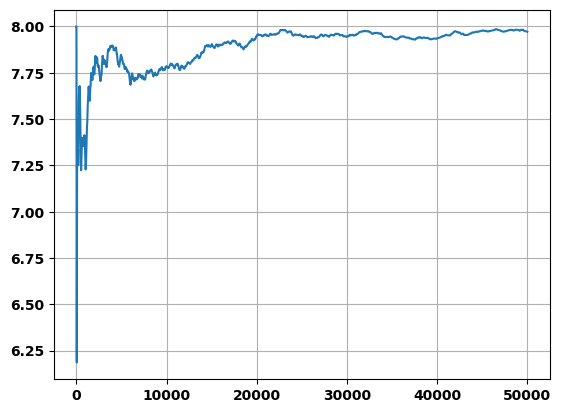

In [39]:
plt.plot(l_a)
print(l_a[-1])
#plt.ylim(1,2)
plt.grid(True)
#plt.axhline(y=1.5)


Text(0.5, 1.0, 'Illustration of late time state with additional cells added')

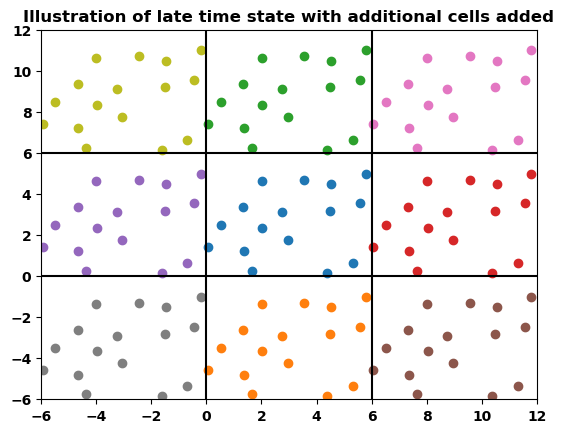

In [24]:
test=-100
plt.scatter(x_1[test],y_1[test])
plt.scatter(x_1[test],[m-6 for m in y_1[test]])
plt.scatter(x_1[test],[m+6 for m in y_1[test]])
plt.scatter([m+6 for m in x_1[test]],y_1[test])
plt.scatter([m-6 for m in x_1[test]],y_1[test])
plt.scatter([m+6 for m in x_1[test]],[m-6 for m in y_1[test]])
plt.scatter([m+6 for m in x_1[test]],[m+6 for m in y_1[test]])
plt.scatter([m-6 for m in x_1[test]],[m-6 for m in y_1[test]])
plt.scatter([m-6 for m in x_1[test]],[m+6 for m in y_1[test]])
plt.axvline(x=6,color='black')
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.axhline(y=6,color='black')
plt.xlim(-6,12)
plt.ylim(-6,12)
plt.title("Illustration of late time state with additional cells added")

## D ##

In [11]:
x_D0=[]
y_D0=[]
vx_D0=[]
vy_D0=[]
lDx=lDy=10
#print(*range(1,12))
for i in range(1,12):
    x_D0.append(lDx/2)
    y_D0.append((i-0.5)*(lDy/11))
    vx_D0.append(1)
    vy_D0.append(0)
print(len(x_D0))
print(y_D0)

11
[0.45454545454545453, 1.3636363636363635, 2.2727272727272725, 3.1818181818181817, 4.090909090909091, 5.0, 5.909090909090909, 6.818181818181818, 7.727272727272727, 8.636363636363637, 9.545454545454545]


In [34]:
u_D,k_D,l_D,x_D,y_D,vx_D,vy_D,ax_D,ay_D=Mover(x_D0,y_D0,vx_D0,vy_D0,1000,dt=0.02,L=lDx)

(0.0, 10.0)

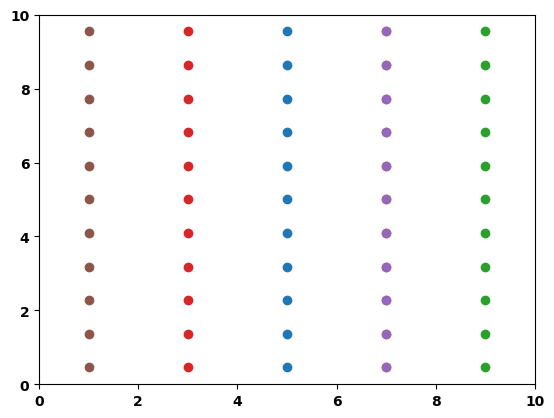

In [35]:
plt.scatter(x_D[0],y_D[0])
plt.scatter(x_D[100],y_D[100])
plt.scatter(x_D[200],y_D[200])
plt.scatter(x_D[400],y_D[400])
plt.scatter(x_D[600],y_D[600])
plt.scatter(x_D[800],y_D[800])
plt.xlim(0,10)
plt.ylim(0,10)

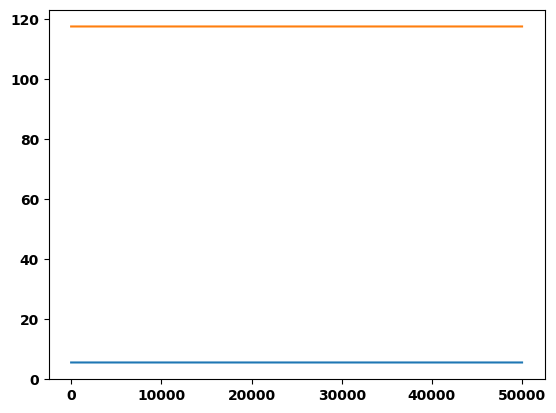

In [36]:
plt.plot(k_D)
plt.plot(u_D)

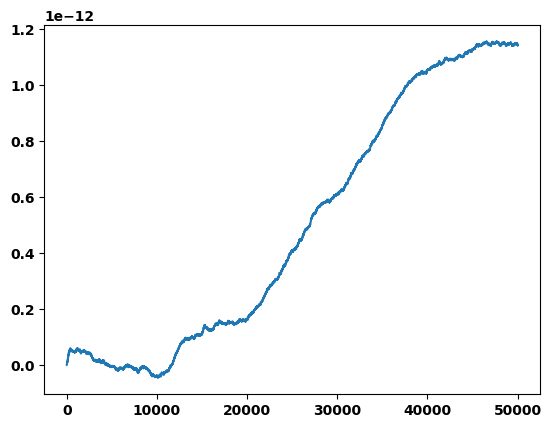

In [40]:
#plt.plot([el[1] for el in vx_D])
plt.plot([np.sum(el) for el in vy_D])
#plt.ylim(0.999999999999999,1.0000000000000001)
#print(len(vx_D[1][:]))
#print(np.shape(vx_D[1]))
#print(len([el[1] for el in vx_D]))

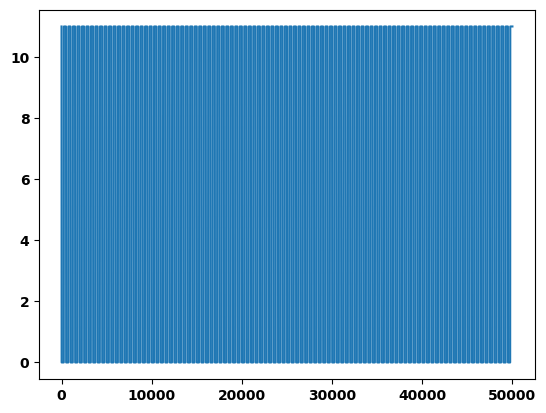

In [27]:
plt.plot(l_D)

In [31]:
x_D0a=x_D0[:]
y_D0a=y_D0[:]
vx_D0a=vx_D0[:]
vy_D0a=vy_D0[:]
print(len(x_D0a))
print(len(x_D0))
vx_D0a[5]=0.99
vy_D0a[5]=0.01
print(vy_D0a)


11
11
[0, 0, 0, 0, 0, 0.01, 0, 0, 0, 0, 0]


In [32]:
u_Da,k_Da,l_Da,x_Da,y_Da,vx_Da,vy_Da,ax_Da,ay_Da=Mover(x_D0a,y_D0a,vx_D0a,vy_D0a,1000,dt=0.01,L=lDx)

(0.0, 10.0)

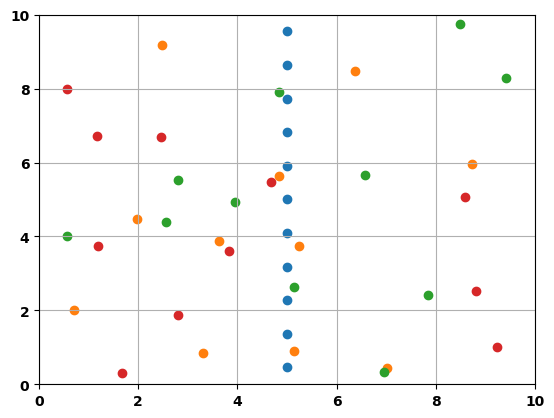

In [33]:
plt.scatter(x_Da[0],y_Da[0])
#plt.scatter(x_Da[100],y_Da[100])
#plt.scatter(x_Da[300],y_Da[300])
#plt.scatter(x_Da[500],y_Da[500])
#plt.scatter(x_Da[1000],y_Da[1000])
plt.scatter(x_Da[5500],y_Da[5500])
plt.scatter(x_Da[8500],y_Da[8500])
plt.scatter(x_Da[-1],y_Da[-1])
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,10)

Text(0.5, 1.0, 'Illustration of late time state with additional cells added')

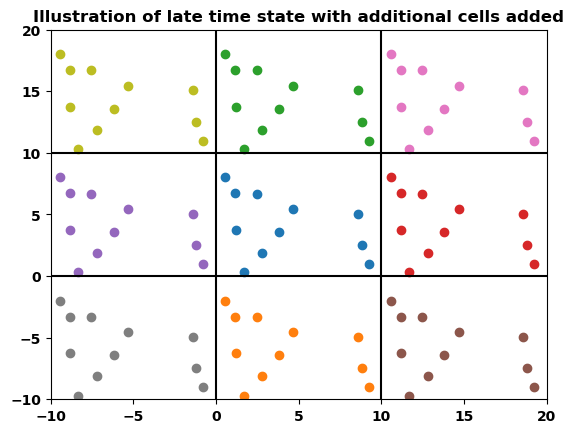

In [34]:
test=-1
plt.scatter(x_Da[test],y_Da[test])
plt.scatter(x_Da[test],[m-10 for m in y_Da[test]])
plt.scatter(x_Da[test],[m+10 for m in y_Da[test]])
plt.scatter([m+10 for m in x_Da[test]],y_Da[test])
plt.scatter([m-10 for m in x_Da[test]],y_Da[test])
plt.scatter([m+10 for m in x_Da[test]],[m-10 for m in y_Da[test]])
plt.scatter([m+10 for m in x_Da[test]],[m+10 for m in y_Da[test]])
plt.scatter([m-10 for m in x_Da[test]],[m-10 for m in y_Da[test]])
plt.scatter([m-10 for m in x_Da[test]],[m+10 for m in y_Da[test]])
plt.axvline(x=10,color='black')
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.axhline(y=10,color='black')
plt.xlim(-10,20)
plt.ylim(-10,20)
plt.title("Illustration of late time state with additional cells added")

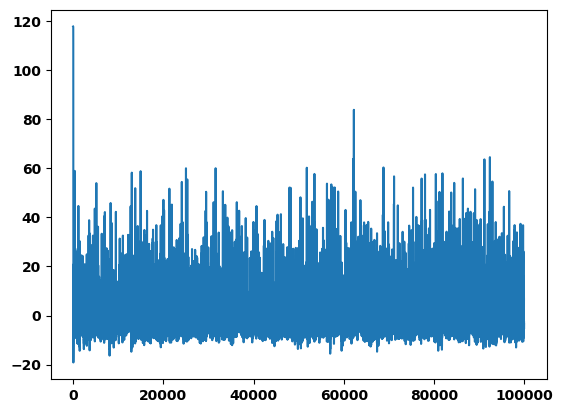

In [35]:
plt.plot(u_Da)

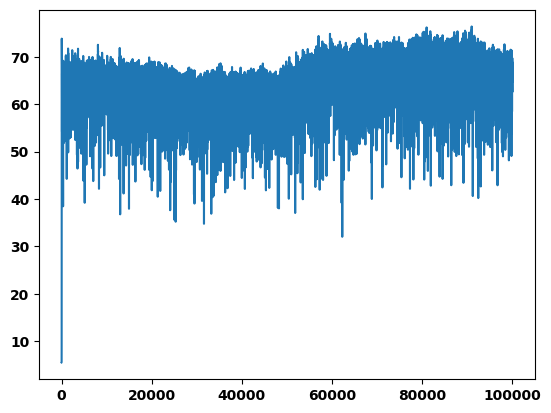

In [36]:
plt.plot(k_Da)

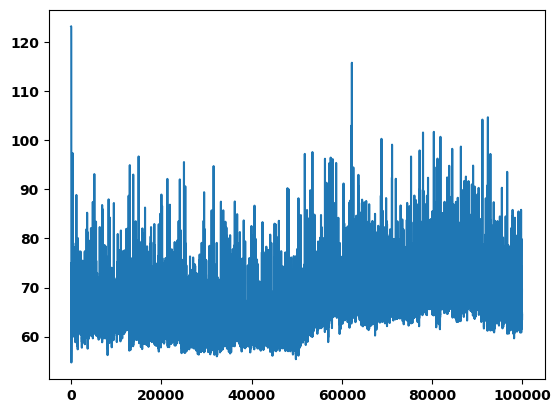

In [37]:
E_tota=[]
for i in range(0,len(k_Da)):
    E_tota.append(k_Da[i]+u_Da[i])
plt.plot(E_tota)

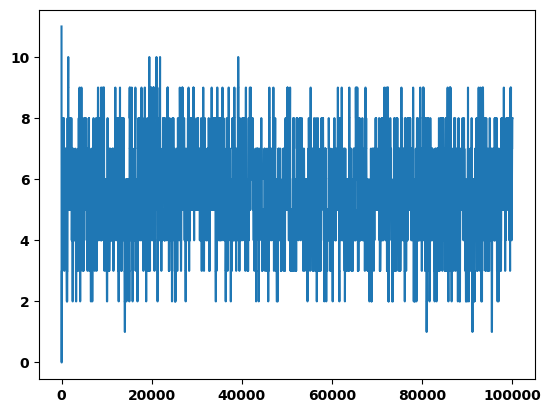

In [38]:
plt.plot(l_Da)

In [39]:
l_Da_avg=[]
for i in range(0,len(l_Da)):
    l_Da_avg.append(np.average(l_Da[0:i]))

5.52504


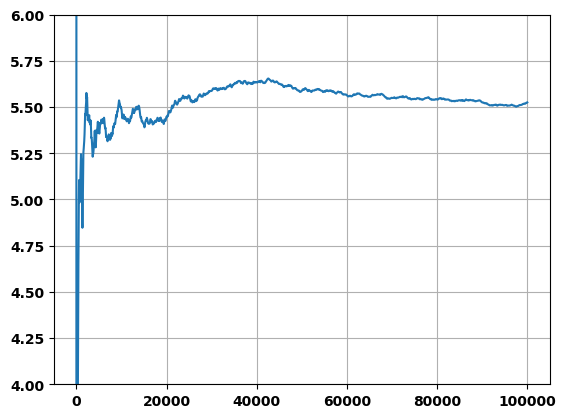

In [40]:
plt.plot(l_Da_avg)
print(l_Da_avg[-1])
plt.ylim(4,6)
plt.grid(True)
#plt.axhline(y=1.5)


## E ##

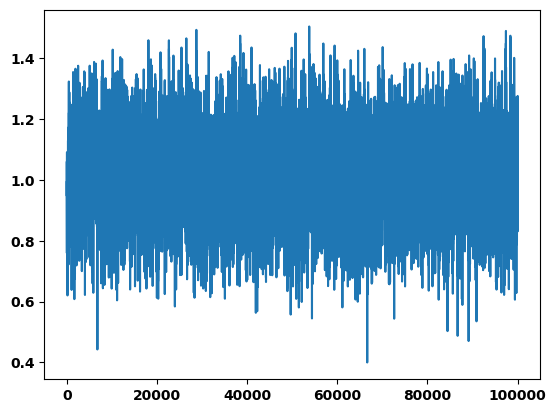

In [41]:

Temp=[]
for i in range(0,len(vx_1)):
    dummylist=[]
    for j in range(0,len(vx_1[i])):
        prod=(1/30)*((vx_1[i][j])**2+(vy_1[i][j])**2)
        dummylist.append(prod)
    Temp.append(np.sum(dummylist))
plt.plot(Temp)
#plt.xlim(0,100)
#plt.ylim(0,1e+2)

[nan, 0.9527183964234789, 0.9653555768644662, 0.9784275730816597, 0.9893842569623531, 0.9972855135692393, 1.0026917982205987, 1.0070012738158793, 1.01165531966001, 1.0175860832048476, 1.0250564521083636, 1.0337750587168189, 1.043075551490628, 1.0520545567466562, 1.059678040097358, 1.064902213648565, 1.066861739087623, 1.0651549006101815, 1.0601768276484096, 1.0532402098872702, 1.04614240619663, 1.0403219683747835, 1.0363461090947583, 1.0341734403716993, 1.0337279506508108, 1.035075638333379, 1.038148314831683, 1.0425065741677193, 1.0474145760116635, 1.052090844645121, 1.055949599716199, 1.0587311977086347, 1.060461842857088, 1.0613030757163913, 1.0614930340882642, 1.0614628243698512, 1.0618481469050896, 1.0631014356723003, 1.065017559514074, 1.0667207813409745, 1.067141802708059, 1.0656949377890523, 1.0627292946553477, 1.059214883881336, 1.0559331884565244, 1.0531773869888121, 1.05108222162972, 1.0499193708426724, 1.0500232445021391, 1.0515324824073773, 1.0542797541124969, 1.0579024529

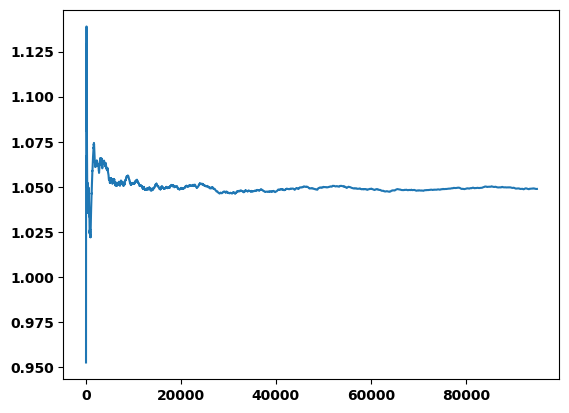

In [42]:
Red_Avg_temp=[]
for i in range (5000,len(Temp)):
    Red_Avg_temp.append(np.average(Temp[5000:i]))
print(Red_Avg_temp)
plt.plot(Red_Avg_temp)

1.0488562094673344


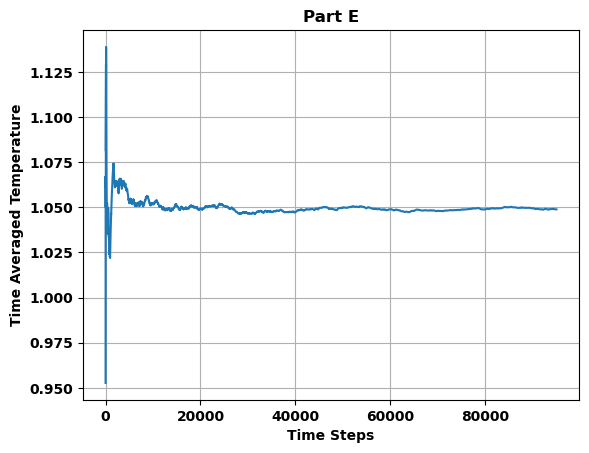

In [43]:
plt.plot(Red_Avg_temp)
plt.xlabel("Time Steps")
plt.ylabel("Time Averaged Temperature")
plt.grid(True)
plt.title("Part E")
print(Red_Avg_temp[-1])

In [44]:
v_avg=[]
for i in range(20000,len(vx_1)):
    dummy_vels=[]
    for j in range(0,len(vx_1[i])):
        v=np.sqrt(vx_1[i][j]**2+vy_1[i][j]**2)
        dummy_vels.append(v)
    v_avg.append(dummy_vels)
print(np.shape(v_avg))

(80001, 16)


1280016
0.9845442534450745 2.0586267943056975
0.0059927048746352025 0.01294149259639254


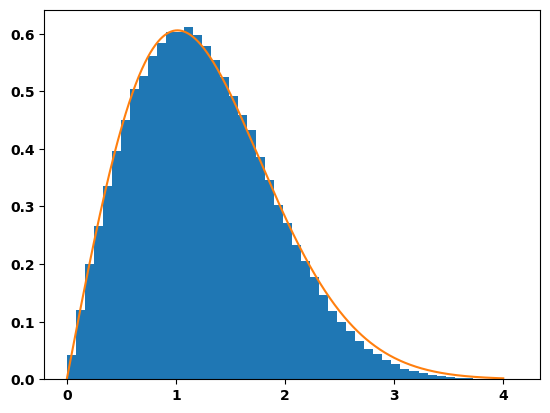

In [45]:
#Using density function
v_avgn=np.asarray(v_avg)
print(len(v_avgn.flatten()))
#Doing it this way allows me to only plot it once while referencing the values multiple times
data,edges,object1=plt.hist(v_avgn.flatten(),50,density=True)
#Defining curvefit function
def P(x,A,T):
    return A*x*np.exp((-x**2)/T)
#hist returns the edges put we want to curve fit to the midpoints
midpoints=[]
for i in range(0,len(edges)-1):
    midpoints.append(0.5*(edges[i]+edges[i+1]))
popt,pcov=curve_fit(P,midpoints,data,[1,2.1])
vel_space=np.linspace(0,4,1000)
#plt.plot(vel_space,P(vel_space,60000,2.1))
plt.plot(vel_space,P(vel_space,popt[0],popt[1]))
print(popt[0],popt[1])
print(np.sqrt(pcov[0][0]),np.sqrt(pcov[1][1]))
#print(midpoints[0],midpoints[-1])
#print(plt.hist(v_avgn.flatten(),50)[0])

In [40]:
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/u_1_002.txt",u_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/k_1_002.txt",k_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_1_002.txt",l_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/x_1_002.txt",x_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/y_1_002.txt",y_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vx_1_002.txt",vx_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vy_1_002.txt",vy_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ax_1_002.txt",ax_1)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ay_1_002.txt",ay_1)
#np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_a.txt",l_a)


In [53]:
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/u_D.txt",u_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/k_D.txt",k_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_D.txt",l_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/x_D.txt",x_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/y_D.txt",y_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vx_D.txt",vx_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vy_D.txt",vy_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ax_D.txt",ax_D)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ay_D.txt",ay_D)

In [54]:
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/u_Da.txt",u_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/k_Da.txt",k_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_Da.txt",l_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/x_Da.txt",x_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/y_Da.txt",y_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vx_Da.txt",vx_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vy_Da.txt",vy_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ax_Da.txt",ax_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ay_Da.txt",ay_Da)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_Da_avg.txt",l_Da_avg)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/Red_Avg_temp.txt",Red_Avg_temp)


In [28]:
#This was the original way I calculated P but I since removed the code and can't seem to be able to revert
def Net_Force_U_Calc_mod(dxs,dys):
    calccount=0
    ra=np.zeros(np.shape(dxs))
    x_forces=np.zeros(np.shape(dxs))
    y_forces=np.zeros(np.shape(dys))
    U_array=np.zeros(np.shape(dxs))
    for i in range(0,len(dxs)):
        for j in range (0,len(dxs[i])):
            if (dxs[i][j]!=np.nan) & (dys[i][j]!=np.nan)&(np.abs(x_forces[i][j])<1e-9)&(np.abs(y_forces[i][j])<1e-9):
                #print(i,j)
                F_x,F_y=Force_calc(dxs[i][j],dys[i][j])
                Pot=Pot_calc(dxs[i][j],dys[i][j])
                rsquare=(dxs[i][j]**2+dys[i][j]**2)
                ra[j][i]=ra[i][j]=(rsquare**(-6))-0.5*(rsquare**(-3))
                calccount+=1
                #It looks like its counting a few too many times? Should be 120 but is doing 136
                #This takes advantage of NIII
                x_forces[i][j]=F_x
                x_forces[j][i]=-F_x
                y_forces[i][j]=F_y
                y_forces[j][i]=-F_y
                U_array[i][j]=Pot
                U_array[j][i]=Pot

    #print(calccount)
    Net_x_Forces=[np.nansum(el) for el in x_forces]
    Net_y_Forces=[np.nansum(el) for el in y_forces]
    Net_Potentials=[np.nansum(el) for el in U_array]
    Net_ra=[np.nansum(el) for el in ra]

    return Net_x_Forces,Net_y_Forces,Net_Potentials,Net_ra
                


In [29]:
def Mover_mod(Posx0,Posy0,v_x0,v_y0,tmax,dt=0.01,L=6):
    Tot_Pots=[]
    Tot_kin=[]
    Left_nums=[]
    x_array=[]
    y_array=[]
    vx_array=[]
    vy_array=[]
    ax_array=[]
    ay_array=[]
    ras=[]
    #The : in the following statements are to make copies to prevent changing original
    x0=Posx0[:]
    y0=Posy0[:]
    vx0=v_x0[:]
    vy0=v_y0[:]
    ax0=np.zeros(len(Posx0))
    ay0=np.zeros(len(Posx0))
    ax1=np.zeros(len(Posx0))
    ay1=np.zeros(len(Posx0))
    t=0
    while t<tmax:
        #Get nearest distances
        dxs=Distances_to_Nearests(x0,L)
        dys=Distances_to_Nearests(y0,L)
        #Get x,y net forces and potential
        xf,yf,FPots,ra=Net_Force_U_Calc_mod(dxs,dys)
        Tot_Pots.append(np.nansum(FPots))
        ras.append(np.sum(ra))
        #Get kinetic energy
        Tot_kin.append(np.sum([0.5*v**2 for v in vx0]+[0.5*v**2 for v in vy0]))
        #Get number of molecules on left side
        Left_num=len([x for x in x0 if 0<=x<=L/2])
        Left_nums.append(Left_num)
        #prep for movement by noting current values 
        x_array.append(x0)
        y_array.append(y0)
        vx_array.append(vx0)
        vy_array.append(vy0)
        ax_array.append(ax1)
        ay_array.append(ay1)
        #movement
        ax0=xf[:]
        ay0=yf[:]
        #This copy stuff was found to be needed due to way python decides to work in terms of value by reference
        #The issue was that it was computing the new values, replacing the values and then duplicating these new values
        copy_x0=x0[:]
        copy_y0=y0[:]
        copy_vx0=vx0[:]
        copy_vy0=vy0[:]
        for i in range(0,len(x0)):
            copy_x0[i]=pos1(x0[i],vx0[i],ax0[i],dt)
            copy_y0[i]=pos1(y0[i],vy0[i],ay0[i],dt)
            #copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
            #copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt)
            if copy_x0[i]>L:
                #print('test1',copy_x0[i])
                copy_x0[i]=copy_x0[i]%L
                #print(copy_x0[i])
            if copy_x0[i]<0:
                #print('test2',copy_x0[i])
                copy_x0[i]=L-np.abs(copy_x0[i])%L
                #print(copy_x0[i])
            if copy_y0[i]>L:
                #print('test3',copy_y0[i])
                copy_y0[i]=copy_y0[i]%L
                #print(copy_y0[i])
            if copy_y0[i]<0:
                #print('test4',copy_y0[i])
                copy_y0[i]=L-np.abs(copy_y0[i])%L
                #print(copy_y0[i])
        #This duplication of things is likely not particularly efficient
        dxs1=Distances_to_Nearests(copy_x0,L)
        dys1=Distances_to_Nearests(copy_y0,L)
        xf1,yf1,FPots1=Net_Force_U_Calc(dxs1,dys1)
        ax1=xf1[:]
        ay1=yf1[:]
        for i in range(0,len(x0)):
           copy_vx0[i]=vel1(vx0[i],ax1[i],ax0[i],dt)
           copy_vy0[i]=vel1(vy0[i],ay1[i],ay0[i],dt) 
        x0=copy_x0[:]
        y0=copy_y0[:]
        vx0=copy_vx0[:]
        vy0=copy_vy0[:]
        ax0=ax1[:]
        ay0=ay1[:]


        t+=dt
    #print(np.shape(x_array))
    return Tot_Pots,Tot_kin,Left_nums,x_array,y_array,vx_array,vy_array,ax_array,ay_array,ras

In [30]:
u_p,k_p,l_p,x_p,y_p,vx_p,vy_p,ax_p,ay_p,ra=Mover_mod(x,y,v_x,v_y,1000,dt=0.01)

-0.7919799331973076


c:\Users\gjc10\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\gjc10\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


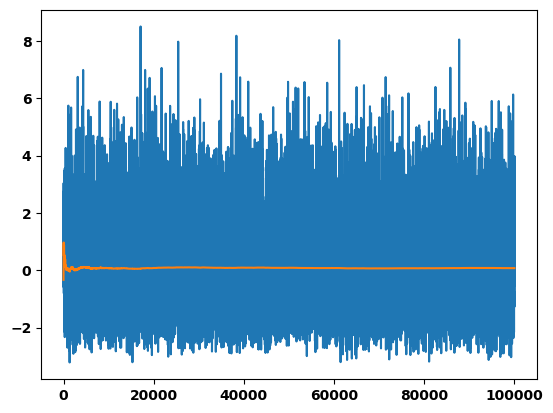

In [36]:
print(ra[-1])
plt.plot(ra)
ra_avg=[]
for i in range(0,len(ra)):
    ra_avg.append(np.average(ra[0:i]))
plt.plot(ra_avg)

0.07088084940931812
100001


(-0.1, 0.2)

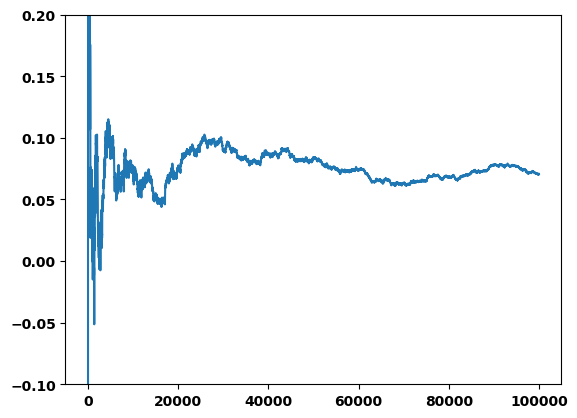

In [37]:
print(ra_avg[-1])
print(len(ra_avg))
plt.plot(ra_avg)
plt.ylim(-0.1,0.2)

In [38]:
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/u_p_new.txt",u_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/k_p_new.txt",k_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/l_p_new.txt",l_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/x_p_new.txt",x_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/y_p_new.txt",y_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vx_p_new.txt",vx_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/vy_p_new.txt",vy_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ax_p_new.txt",ax_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ay_p_new.txt",ay_p)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ra_new.txt",ra)
np.savetxt("C:/Users/gjc10/Desktop/4th year labs/Computational Lab/results_save/ra_avg_new.txt",ra_avg)